# Initialization

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *
from __future__ import division, print_function
path = "data/weather/"
model_path = path + 'models/'

Using TensorFlow backend.


## Model params

- `batch_size` is the training minibatch size: 64-128 seems to work fairly well
- `seq_length` is the number of time samples spread through the previous week to feed into the model for prediction.  32 might be overkill but gives a lot of data for the model to spot patterns on.
- `fp_fn_ratio` is the relative cost of a false negative over a false postive.  That is, if set to `10`, then *not* turning on the sprinklers when there is a frost is considered to be 10x as bad as turning on the sprinklers when there is no frost.

In [3]:
batch_size=128
seq_length=32
fp_fn_ratio=10

# Historic Data

## Actuals from Wunderground

We read in the raw historic data from the CSV file that we pulled from Wunderground using https://github.com/CienegaOrchards/weather-download

The timestamps in there are UTC, but we care about local time, so adjust for that.
Some rows are duplicated in the CSV for some reason; so trim those.  There's also some entries where the data is corrupted, so remove those too.

Then, what we want to try and predict is whether or not the temperature will drop below some threshold within the next 10 hours.  So we do a rolling window looking forward 10 hours and figure out what the minimum temperature will be in that time.  Pandas doesn't do rolling windows forward, so we do a rolling window backwards and then shift that by 10 hours.

Once we have the rolling look-forward minimums, we also figure out the day-of-year (which the model can use to infer seasonal weather patterns), and hour-of-day (so the model can figure out daily patterns).

We then construct a field called `threshold` which tracks whether the look-ahead temp crosses some threshold temp.  We can have a model that tries to forecast *which* threshold we cross by introducing multiple thresholds here, or just have a single threshold.  Then we one-hot that threshold field.

In [4]:
data = pd.read_csv(path + 'all_data.csv', index_col='DateUTC', parse_dates=['DateUTC'],
                   usecols=['DateUTC','TemperatureF','DewpointF','PressureIn',
                            'WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn',
                            'dailyrainin','SolarRadiationWatts/m^2'])
data.index = data.index.tz_localize('UTC', ambiguous='infer') #.tz_convert('US/Pacific')
data.drop_duplicates(inplace=True)

data = data[data.TemperatureF > 0] # Remove bad temp
data = data[data.PressureIn   > 0] # Remove bad pressure
data = data[data.HourlyPrecipIn >= 0] # Remove bad rainfall

data = data.assign(forward_min = data.rolling('10h', closed='both').TemperatureF.min().shift(-1,'10h').asof(data.index))

data = data.assign(day_of_year = data.index.dayofyear, hour = data.index.hour)
data = data.assign(threshold = 'no')
data.loc[data.forward_min < 32,'threshold'] = '32'
# data.loc[data.forward_min < 30,'threshold'] = '30'
# data.loc[data.forward_min < 28,'threshold'] = '28'

data = data.merge(pd.get_dummies(data.threshold, prefix='threshold'), left_index=True, right_index=True)

data.head()

,TemperatureF,DewpointF,PressureIn,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min,day_of_year,hour,threshold,threshold_32,threshold_no
DateUTC,,,,,,,,,,,,,,,
2016-02-16 19:12:00+00:00,73.8,50.5,29.29,0.0,0.0,44,0.0,0.0,17.48,73.8,47,19,no,0,1
2016-02-16 19:14:00+00:00,74.5,50.5,29.29,0.0,0.0,43,0.0,0.0,17.48,73.8,47,19,no,0,1
2016-02-16 19:15:00+00:00,74.5,50.5,29.28,0.0,0.0,43,0.0,0.0,17.48,73.8,47,19,no,0,1
2016-02-16 19:16:00+00:00,74.5,50.5,29.27,0.0,0.0,43,0.0,0.0,17.53,73.8,47,19,no,0,1
2016-02-16 19:23:00+00:00,74.5,50.0,29.96,0.0,0.0,42,0.0,0.0,17.43,73.8,47,19,no,0,1


## Historic forecasts as recorded in Dynamo weather_log table

In [5]:
forecasts = pd.read_csv(path+'forecast-current-2017-08-08-14-25-45.csv', parse_dates=['time'], index_col='time', usecols=['time','forecast'], dtype={'forecast': 'float'})
forecasts = forecasts.tz_localize('UTC', ambiguous='infer') #.tz_convert('US/Pacific')

data = data.assign(forecast = forecasts.asof(data.index)).dropna()
data.head()

,TemperatureF,DewpointF,PressureIn,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min,day_of_year,hour,threshold,threshold_32,threshold_no,forecast
DateUTC,,,,,,,,,,,,,,,,
2016-02-29 01:32:00+00:00,61.2,49.3,30.13,0.0,0.0,65,0.0,0.0,10.68,38.8,60,1,no,0,1,58.0
2016-02-29 01:37:00+00:00,60.8,48.9,30.14,0.0,0.0,65,0.0,0.0,8.39,38.8,60,1,no,0,1,58.0
2016-02-29 01:42:00+00:00,60.6,49.6,30.13,0.0,0.0,67,0.0,0.0,6.21,38.8,60,1,no,0,1,58.0
2016-02-29 01:47:00+00:00,60.3,49.6,30.13,0.0,0.0,68,0.0,0.0,1.43,38.8,60,1,no,0,1,58.0
2016-02-29 01:57:00+00:00,59.7,51.1,30.13,0.0,0.0,73,0.0,0.0,0.00,38.8,60,1,no,0,1,58.0


## Sequence of dates back in time with exponential steps

The idea here is that we want to make predictions based on the most-recent week's worth of weather data; so we'll take the historic actuals, and snapshot at intervals going back in time, starting with current data; then 30 minutes ago; then `30*m` where `m` is some multiple, up to `30*(m^x)` where x is enough iterations to reach a total of 1 week (`60*24*7` minutes) of data.  The sequence length is how many data points there'll be feeding into the prediction engine, and the math will space those out in an exponential curve so that we have more data points which are more recent in time, and fewer as we reach back towards a week ago.

In [6]:
minutes_in_week = 60*24*7+30
base = 30
multiple = np.exp(np.log(minutes_in_week/base)/(seq_length-1))
from pandas.tseries.offsets import *
offsets = pd.Series(DateOffset(minutes = base*(multiple**i-1)) for i in range(seq_length-1,-1,-1))
offsets

0     <DateOffset: kwds={'minutes': 10079.99999999998}>
1     <DateOffset: kwds={'minutes': 8349.434435135774}>
2     <DateOffset: kwds={'minutes': 6915.09608830260...
3     <DateOffset: kwds={'minutes': 5726.27866643419...
4     <DateOffset: kwds={'minutes': 4740.95545754265...
5     <DateOffset: kwds={'minutes': 3924.29361517625...
6     <DateOffset: kwds={'minutes': 3247.42275822408...
7     <DateOffset: kwds={'minutes': 2686.41435398226...
8     <DateOffset: kwds={'minutes': 2221.43580394224...
9     <DateOffset: kwds={'minutes': 1836.04932779933...
10    <DateOffset: kwds={'minutes': 1516.630860041915}>
11    <DateOffset: kwds={'minutes': 1251.88841613045...
12    <DateOffset: kwds={'minutes': 1032.46290169388...
13    <DateOffset: kwds={'minutes': 850.5972526714213}>
14    <DateOffset: kwds={'minutes': 699.862209942718...
15     <DateOffset: kwds={'minutes': 574.929034114572}>
16    <DateOffset: kwds={'minutes': 471.381125546298...
17    <DateOffset: kwds={'minutes': 385.55789006

## Build the data sequences

Now we actually build the data sequences.  It takes a LONG time to run this; welcome to Python... I haven't been able to come up with a good way to get Pandas to do this more efficiently than having the loop in Python and calling multiply into Pandas native code.  There's possibly some clever way of using Pandas to handle the iteration though by using multiple resamples or shifts or something.  For now, we just run the calculation once then save the resulting data frame so that we can just re-load it and not have to repeat the iteration.  The iteration will need to be re-done though any time the sequence length is changed, or if the time slicing exponential thingie is changed above.  The `all_y` is very fast though, so we can adjust what we're trying to predict with no big penalty -- that doesn't need to be saved/loaded.

In [7]:
#full_data = pd.DataFrame(index=pd.MultiIndex.from_product([data.index.tolist(), offsets.index.tolist()], names=['time','offset']))

In [8]:
data.index = data.index.tz_convert('US/Pacific') # Adjust timezone after date-shifting above to avoid ambiguity which arises when not in UTC

wanted_cols = data[['TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH',
                    'Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2',
                    'day_of_year','hour','forecast']]

# TODO: This below takes about 12 minutes to run on 105,241 data points with seq_length=10.  Surely that could be faster??!?
#       This below takes about 41 minutes to run on 104,733 data points with seq_length=32.  Surely that could be faster??!?

# all_x = np.nan_to_num([wanted_cols.loc[([wanted_cols.index.asof(i) for i in (idx-offsets)])].values for idx in zip(wanted_cols.index)])
# save_array(path+'all_x', all_x)

all_x = load_array(path+'all_x')
all_y = data.threshold_32.values.reshape(-1,1)

all_x.shape, all_y.shape

((104733, 32, 12), (104733, 1))

### Rescale all the things

In [9]:
inputs_scaler = StandardScaler()
num_params = all_x.shape[2]

all_x = inputs_scaler.fit_transform(all_x.reshape(-1,num_params)).reshape(-1,seq_length,num_params)

## Split into Train/Validation

We want to split the data fairly into train/validation data.  There might be patterns in the day-of-the-week based on activity on the ranch, so I don't want to split on day-of-week and use one weekday for validation.  Using `day-of-year%10` seems to be reasonably fair, then we get some of each weekday in both sets.

In [10]:
train_idx = np.where(data.day_of_year%10!=3)
val_idx = np.where(data.day_of_year%10==3)

train_x, train_y = all_x[train_idx], all_y[train_idx]
val_x, val_y = all_x[val_idx], all_y[val_idx]

train_data = data.iloc[train_idx]
validation_data = data.iloc[val_idx]

train_x.shape, train_y.shape, val_x.shape, val_y.shape, train_y.sum(), val_y.sum()

((94126, 32, 12), (94126, 1), (10607, 32, 12), (10607, 1), 4350, 352)

# The Model

I'm going to use a CNN here, where I'm creating convolutions over the time dimension (across the sequence of time-based data points).  This will allow the model to pick up patterns in how the data change over the course of a week, and how those changes can predict our output variable(s).  We use causal padding for replacement in the convolution layers.  I batch-normalize the input data, and then use dropout while training to reduce over-fit.  A small FC hidden layer combines down the features identified by the convolution layers.  When predicting a single threshold, I use binary_crossentropy as my loss function; for multi-threshold I would switch to categorical_crossentropy or more likely top-2 accuracy or something.

In [11]:
model = Sequential([
    GaussianDropout(0.5, input_shape=(seq_length, train_x.shape[2])),
    
    Conv1D(32, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    Conv1D(32, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    MaxPooling1D(),
    BatchNormalization(),

    Conv1D(64, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    Conv1D(64, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    MaxPooling1D(),
    BatchNormalization(),

#     Conv1D(64, 3, padding='causal'),
#     keras.layers.advanced_activations.PReLU(),
#     BatchNormalization(),
#     Conv1D(64, 3, padding='causal'),
#     keras.layers.advanced_activations.PReLU(),
#     MaxPooling1D(),
#     BatchNormalization(),

#     Conv1D(256, 3, padding='causal'),
#     keras.layers.advanced_activations.PReLU(),
#     BatchNormalization(),
#     Conv1D(256, 3, padding='causal'),
#     keras.layers.advanced_activations.PReLU(),
#     MaxPooling1D(),
#     BatchNormalization(),

#     Conv1D(4, 3, padding='same', activation='relu'),
#     MaxPooling1D(),
#     BatchNormalization(),

#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(4),
    
    Flatten(),
    
    Dense(512),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    
    Dropout(0.75),
    Dense(train_y.shape[1], activation='sigmoid'),
])
model.compile(Nadam(), 'binary_crossentropy', ['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_dropout_1 (Gaussian (None, 32, 12)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 32)            1184      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32, 32)            1024      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 32)            3104      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 32, 32)            1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 32)            0         
__________

# Training run

The callback function here will plot a short graph every few epochs to give an indication of how many, and how severe are the false positives & false negatives predicted by the model against the validation data.  Peaks are times where the forward temperature *did* drop below the threshold but the model did not predict so; valleys are where the model predicts a threshold break but the weather did not actually get that cold.

I also have a callback to automatically lower the learning rate when progress stalls.

Train on 94126 samples, validate on 10607 samples
Epoch 1/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.3429 - binary_accuracy: 0.9170

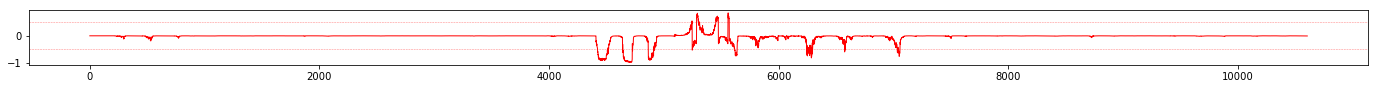

94126/94126 [==============================] - 30s - loss: 0.3428 - binary_accuracy: 0.9170 - val_loss: 0.0806 - val_binary_accuracy: 0.9657
Epoch 2/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.1877 - binary_accuracy: 0.9547

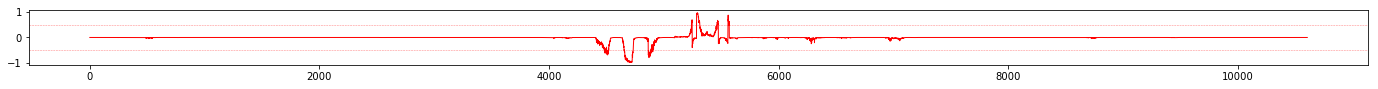

94126/94126 [==============================] - 26s - loss: 0.1877 - binary_accuracy: 0.9546 - val_loss: 0.0408 - val_binary_accuracy: 0.9823
Epoch 3/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.1539 - binary_accuracy: 0.9621

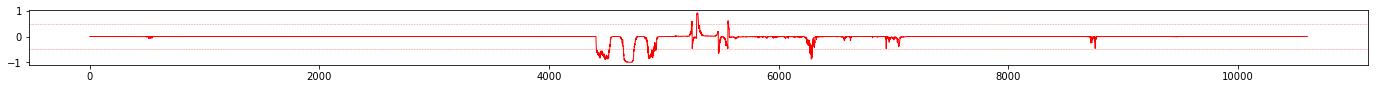

94126/94126 [==============================] - 26s - loss: 0.1539 - binary_accuracy: 0.9621 - val_loss: 0.0712 - val_binary_accuracy: 0.9712
Epoch 4/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.1367 - binary_accuracy: 0.9663

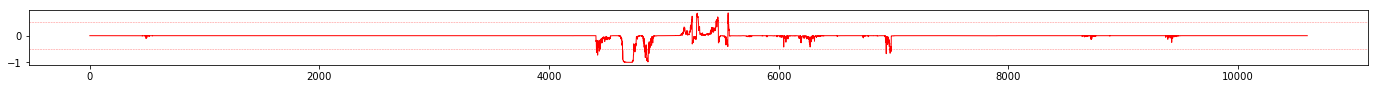

94126/94126 [==============================] - 26s - loss: 0.1369 - binary_accuracy: 0.9662 - val_loss: 0.0720 - val_binary_accuracy: 0.9827
Epoch 5/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.1218 - binary_accuracy: 0.9697

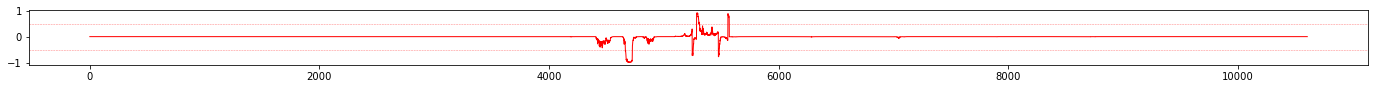

94126/94126 [==============================] - 26s - loss: 0.1218 - binary_accuracy: 0.9697 - val_loss: 0.0350 - val_binary_accuracy: 0.9894
Epoch 6/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.1168 - binary_accuracy: 0.9717

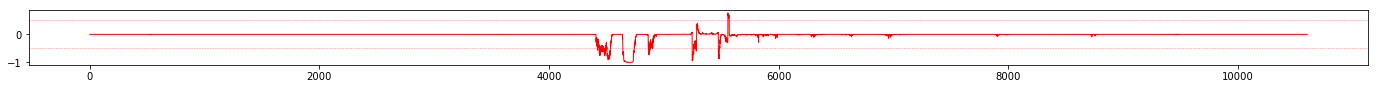

94126/94126 [==============================] - 26s - loss: 0.1168 - binary_accuracy: 0.9716 - val_loss: 0.0729 - val_binary_accuracy: 0.9794
Epoch 7/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.1110 - binary_accuracy: 0.9726- ETA: 0s - loss: 0.1112 - binary_accuracy: 

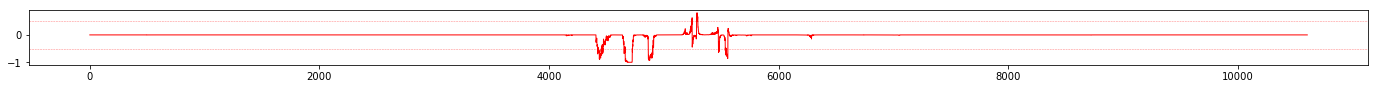

94126/94126 [==============================] - 25s - loss: 0.1110 - binary_accuracy: 0.9727 - val_loss: 0.0521 - val_binary_accuracy: 0.9827
Epoch 8/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.1036 - binary_accuracy: 0.9749- ETA: 2s - loss: 0.1

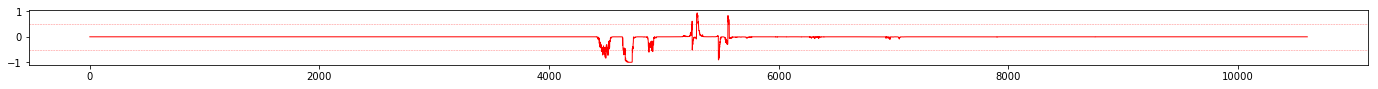

94126/94126 [==============================] - 26s - loss: 0.1036 - binary_accuracy: 0.9749 - val_loss: 0.0453 - val_binary_accuracy: 0.9844
Epoch 9/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0873 - binary_accuracy: 0.9790

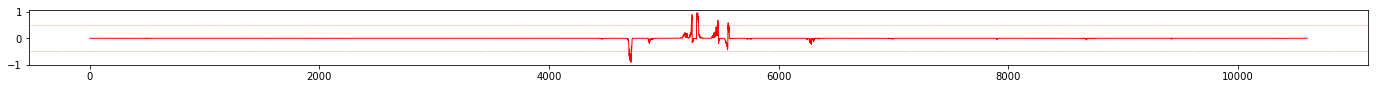

94126/94126 [==============================] - 27s - loss: 0.0874 - binary_accuracy: 0.9790 - val_loss: 0.0124 - val_binary_accuracy: 0.9952
Epoch 10/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9778

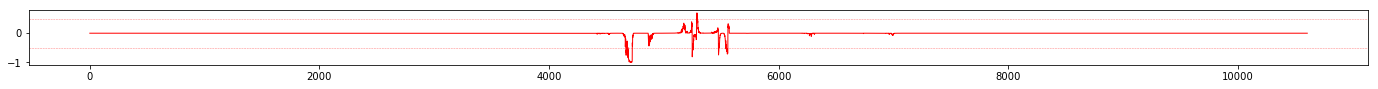

94126/94126 [==============================] - 26s - loss: 0.0920 - binary_accuracy: 0.9778 - val_loss: 0.0216 - val_binary_accuracy: 0.9924
Epoch 11/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0826 - binary_accuracy: 0.9801

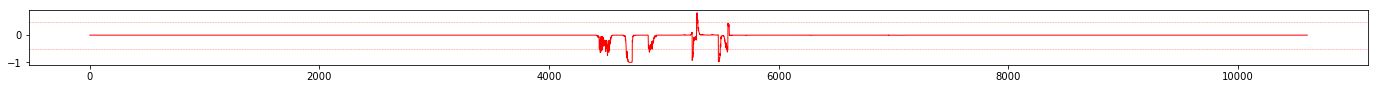

94126/94126 [==============================] - 26s - loss: 0.0825 - binary_accuracy: 0.9801 - val_loss: 0.0380 - val_binary_accuracy: 0.9887
Epoch 12/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0821 - binary_accuracy: 0.9805

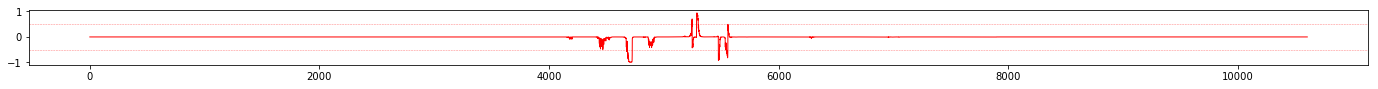

94126/94126 [==============================] - 25s - loss: 0.0821 - binary_accuracy: 0.9805 - val_loss: 0.0249 - val_binary_accuracy: 0.9920
Epoch 13/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0772 - binary_accuracy: 0.9813
Epoch 00012: reducing learning rate to 0.0006000000284984708.


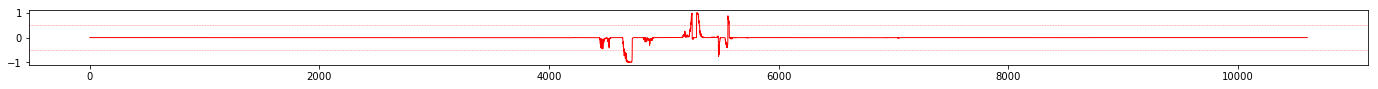

94126/94126 [==============================] - 26s - loss: 0.0772 - binary_accuracy: 0.9813 - val_loss: 0.0380 - val_binary_accuracy: 0.9876
Epoch 14/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0664 - binary_accuracy: 0.9841

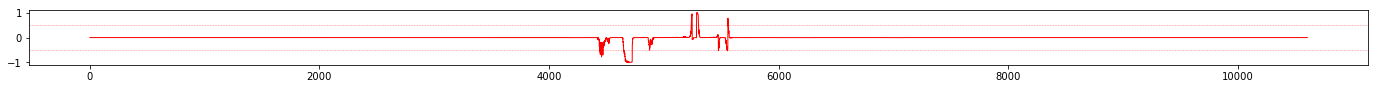

94126/94126 [==============================] - 26s - loss: 0.0665 - binary_accuracy: 0.9840 - val_loss: 0.0411 - val_binary_accuracy: 0.9889
Epoch 15/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0564 - binary_accuracy: 0.9866

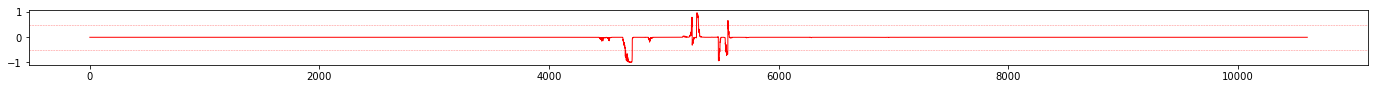

94126/94126 [==============================] - 25s - loss: 0.0567 - binary_accuracy: 0.9866 - val_loss: 0.0292 - val_binary_accuracy: 0.9893
Epoch 16/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0543 - binary_accuracy: 0.9866
Epoch 00015: reducing learning rate to 0.00018000000854954124.


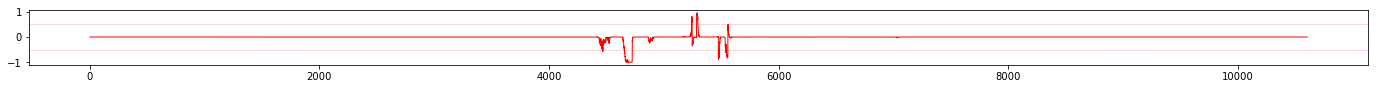

94126/94126 [==============================] - 25s - loss: 0.0545 - binary_accuracy: 0.9866 - val_loss: 0.0368 - val_binary_accuracy: 0.9895
Epoch 17/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0499 - binary_accuracy: 0.9878

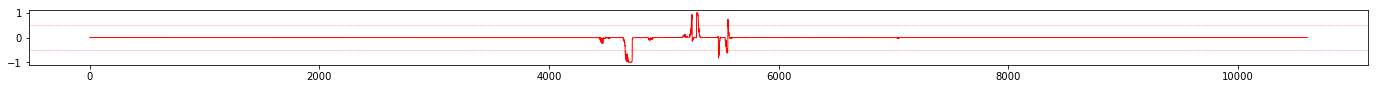

94126/94126 [==============================] - 26s - loss: 0.0499 - binary_accuracy: 0.9878 - val_loss: 0.0311 - val_binary_accuracy: 0.9904
Epoch 18/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0486 - binary_accuracy: 0.9888- ETA: 2s - l

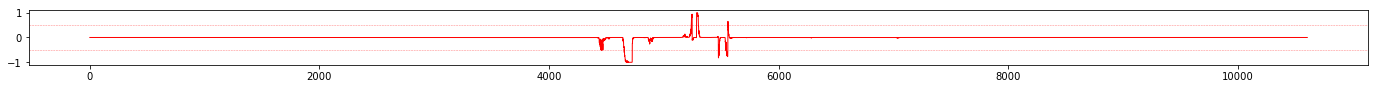

94126/94126 [==============================] - 26s - loss: 0.0486 - binary_accuracy: 0.9888 - val_loss: 0.0429 - val_binary_accuracy: 0.9890
Epoch 19/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0462 - binary_accuracy: 0.9886
Epoch 00018: reducing learning rate to 5.400000081863254e-05.


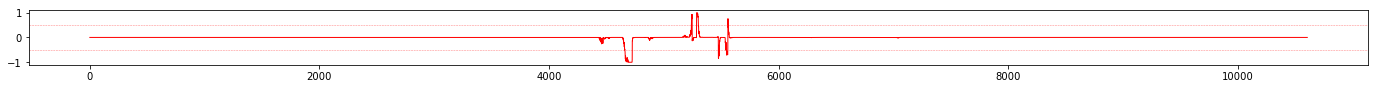

94126/94126 [==============================] - 26s - loss: 0.0462 - binary_accuracy: 0.9886 - val_loss: 0.0351 - val_binary_accuracy: 0.9896
Epoch 20/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0457 - binary_accuracy: 0.9894

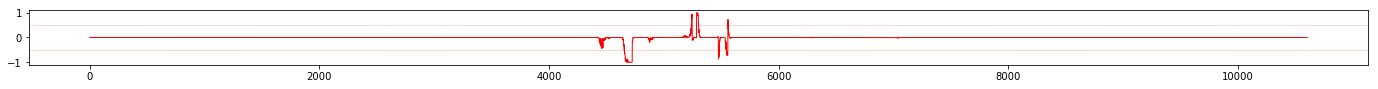

94126/94126 [==============================] - 26s - loss: 0.0457 - binary_accuracy: 0.9894 - val_loss: 0.0389 - val_binary_accuracy: 0.9893
Epoch 21/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0449 - binary_accuracy: 0.9889

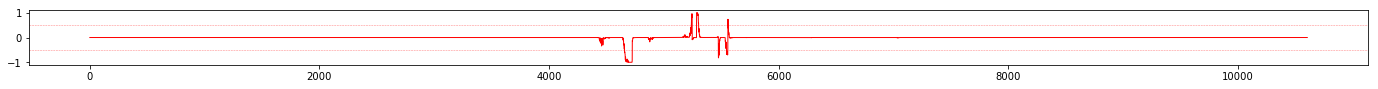

94126/94126 [==============================] - 25s - loss: 0.0448 - binary_accuracy: 0.9889 - val_loss: 0.0377 - val_binary_accuracy: 0.9893
Epoch 22/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0447 - binary_accuracy: 0.9890
Epoch 00021: reducing learning rate to 1.6200000027311033e-05.


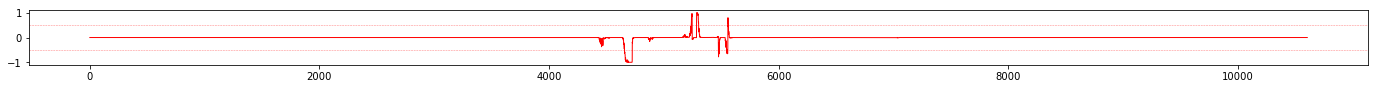

94126/94126 [==============================] - 26s - loss: 0.0447 - binary_accuracy: 0.9890 - val_loss: 0.0393 - val_binary_accuracy: 0.9893
Epoch 23/40
93824/94126 [============================>.] - ETA: 0s - loss: 0.0436 - binary_accuracy: 0.9897

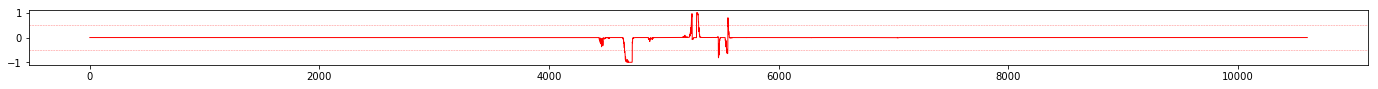

94126/94126 [==============================] - 25s - loss: 0.0436 - binary_accuracy: 0.9897 - val_loss: 0.0391 - val_binary_accuracy: 0.9894
Epoch 24/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0413 - binary_accuracy: 0.9896

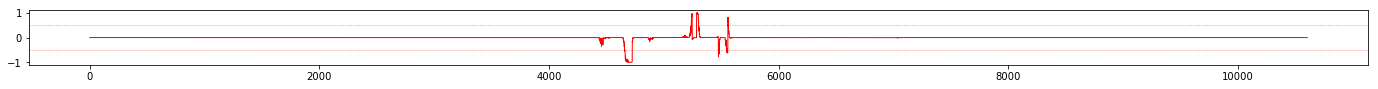

94126/94126 [==============================] - 25s - loss: 0.0413 - binary_accuracy: 0.9896 - val_loss: 0.0379 - val_binary_accuracy: 0.9898
Epoch 25/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0424 - binary_accuracy: 0.9901
Epoch 00024: reducing learning rate to 4.859999899053946e-06.


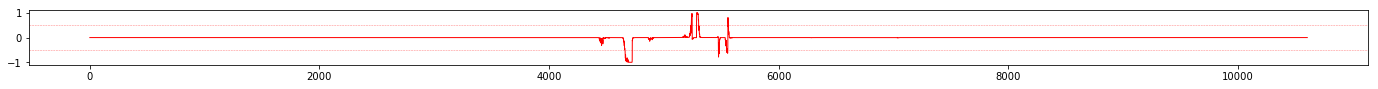

94126/94126 [==============================] - 25s - loss: 0.0424 - binary_accuracy: 0.9901 - val_loss: 0.0367 - val_binary_accuracy: 0.9901
Epoch 26/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0438 - binary_accuracy: 0.9894

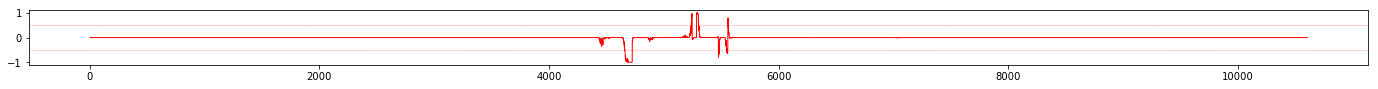

94126/94126 [==============================] - 26s - loss: 0.0438 - binary_accuracy: 0.9894 - val_loss: 0.0375 - val_binary_accuracy: 0.9898
Epoch 27/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0433 - binary_accuracy: 0.9898

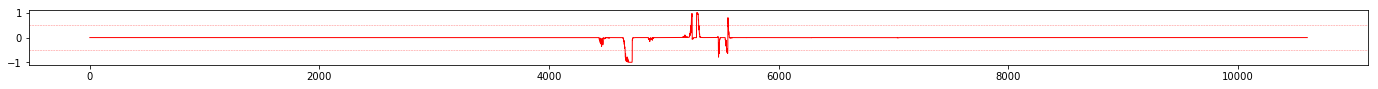

94126/94126 [==============================] - 26s - loss: 0.0433 - binary_accuracy: 0.9897 - val_loss: 0.0358 - val_binary_accuracy: 0.9903
Epoch 28/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0452 - binary_accuracy: 0.9886
Epoch 00027: reducing learning rate to 1.4579999970010249e-06.


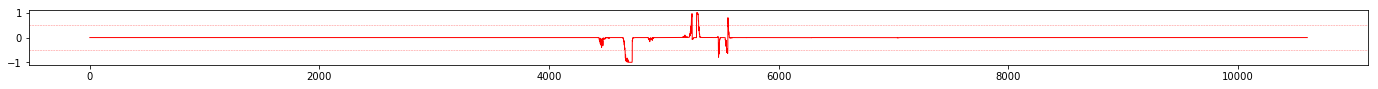

94126/94126 [==============================] - 26s - loss: 0.0452 - binary_accuracy: 0.9887 - val_loss: 0.0368 - val_binary_accuracy: 0.9902
Epoch 29/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0443 - binary_accuracy: 0.9895

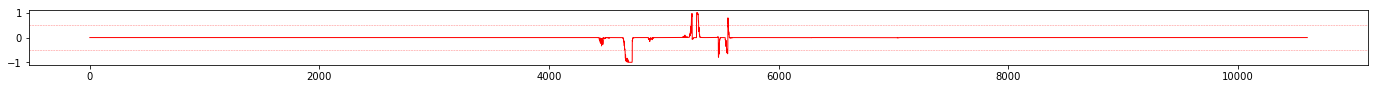

94126/94126 [==============================] - 26s - loss: 0.0442 - binary_accuracy: 0.9895 - val_loss: 0.0368 - val_binary_accuracy: 0.9900
Epoch 30/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0427 - binary_accuracy: 0.9900

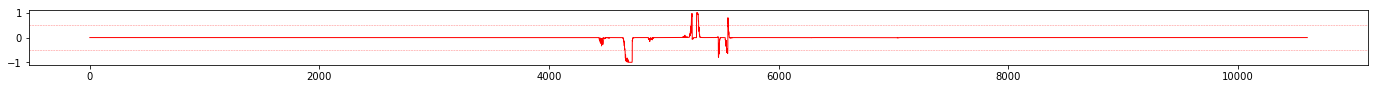

94126/94126 [==============================] - 25s - loss: 0.0426 - binary_accuracy: 0.9900 - val_loss: 0.0367 - val_binary_accuracy: 0.9899
Epoch 31/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0450 - binary_accuracy: 0.9894
Epoch 00030: reducing learning rate to 4.3740001274272796e-07.


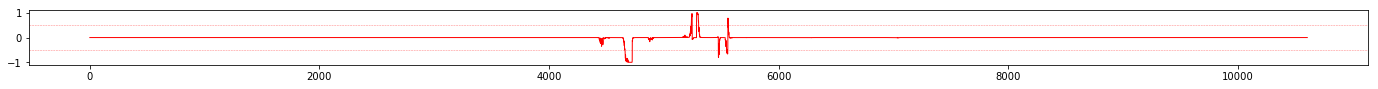

94126/94126 [==============================] - 26s - loss: 0.0450 - binary_accuracy: 0.9894 - val_loss: 0.0371 - val_binary_accuracy: 0.9899
Epoch 32/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0419 - binary_accuracy: 0.9899

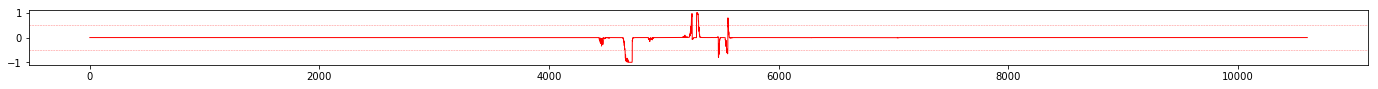

94126/94126 [==============================] - 27s - loss: 0.0419 - binary_accuracy: 0.9899 - val_loss: 0.0369 - val_binary_accuracy: 0.9900
Epoch 33/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0411 - binary_accuracy: 0.9899

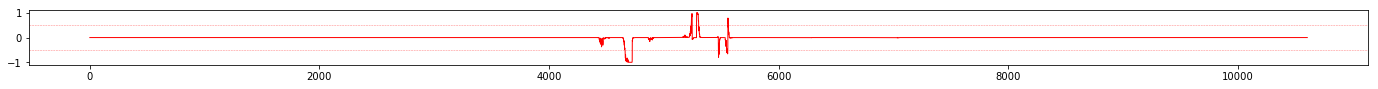

94126/94126 [==============================] - 26s - loss: 0.0411 - binary_accuracy: 0.9898 - val_loss: 0.0368 - val_binary_accuracy: 0.9901
Epoch 34/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0447 - binary_accuracy: 0.9896
Epoch 00033: reducing learning rate to 1.3122000552812096e-07.


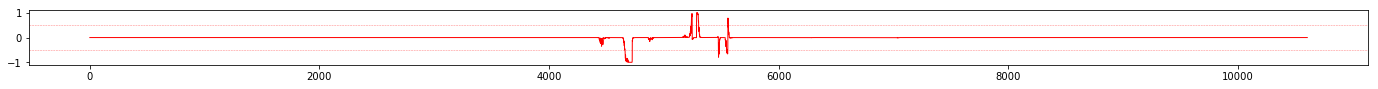

94126/94126 [==============================] - 26s - loss: 0.0447 - binary_accuracy: 0.9895 - val_loss: 0.0371 - val_binary_accuracy: 0.9899
Epoch 35/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0429 - binary_accuracy: 0.9896

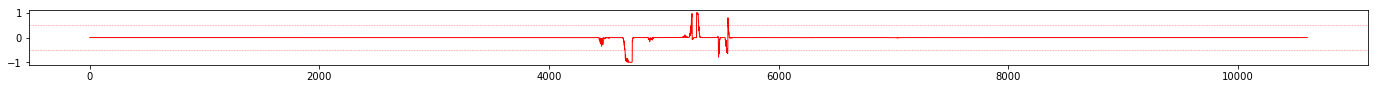

94126/94126 [==============================] - 25s - loss: 0.0429 - binary_accuracy: 0.9896 - val_loss: 0.0371 - val_binary_accuracy: 0.9899
Epoch 36/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0441 - binary_accuracy: 0.9894

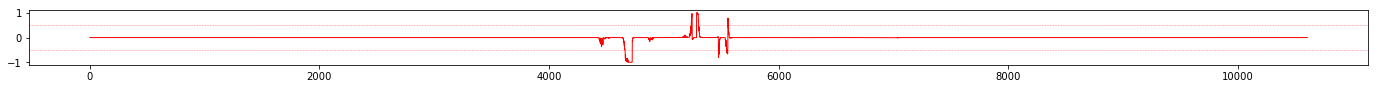

94126/94126 [==============================] - 25s - loss: 0.0441 - binary_accuracy: 0.9894 - val_loss: 0.0371 - val_binary_accuracy: 0.9900
Epoch 37/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0442 - binary_accuracy: 0.9900
Epoch 00036: reducing learning rate to 3.936600165843629e-08.


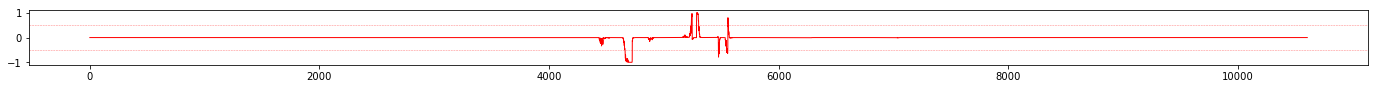

94126/94126 [==============================] - 25s - loss: 0.0442 - binary_accuracy: 0.9900 - val_loss: 0.0371 - val_binary_accuracy: 0.9900
Epoch 38/40
93952/94126 [============================>.] - ETA: 0s - loss: 0.0414 - binary_accuracy: 0.9901

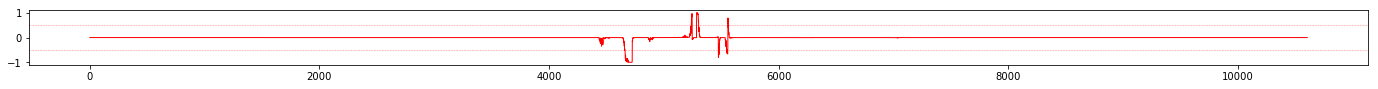

94126/94126 [==============================] - 26s - loss: 0.0414 - binary_accuracy: 0.9901 - val_loss: 0.0372 - val_binary_accuracy: 0.9897
Epoch 39/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0448 - binary_accuracy: 0.9893

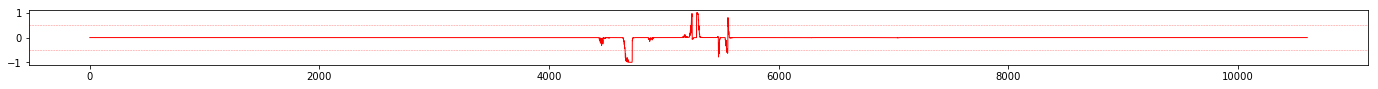

94126/94126 [==============================] - 25s - loss: 0.0448 - binary_accuracy: 0.9893 - val_loss: 0.0363 - val_binary_accuracy: 0.9903
Epoch 40/40
94080/94126 [============================>.] - ETA: 0s - loss: 0.0431 - binary_accuracy: 0.9901
Epoch 00039: reducing learning rate to 1.1809800071205244e-08.


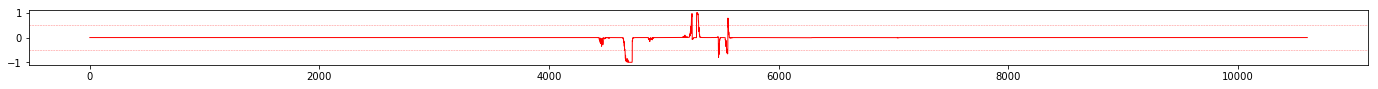

94126/94126 [==============================] - 25s - loss: 0.0431 - binary_accuracy: 0.9901 - val_loss: 0.0373 - val_binary_accuracy: 0.9897


In [12]:
class GraphCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
#         if epoch%2==1:
            plt.figure(figsize=(24,1))
            plt.plot((val_y-(model.predict(val_x, batch_size=batch_size))), 'r', lw=1)
            plt.axhline(0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
            plt.axhline(-0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
            plt.show()

reduce_lr = ReduceLROnPlateau(factor=0.3, patience=3, verbose=1)
graph_cb = GraphCallback()

history = model.fit(train_x, train_y,
          epochs=40,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          class_weight={0:1, 1:fp_fn_ratio, 2:fp_fn_ratio**2},
          callbacks=[reduce_lr, graph_cb])

# Evaluate model

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy', 'lr'])


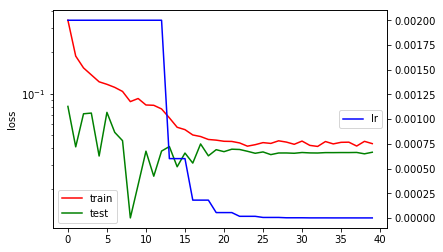

In [13]:
print(history.history.keys())
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_yscale('log')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='g')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'], loc='lower left')
ax2.plot(history.history['lr'], color='b')
ax2.legend(['lr'], loc='center right')
plt.xlabel('epoch')
plt.show()

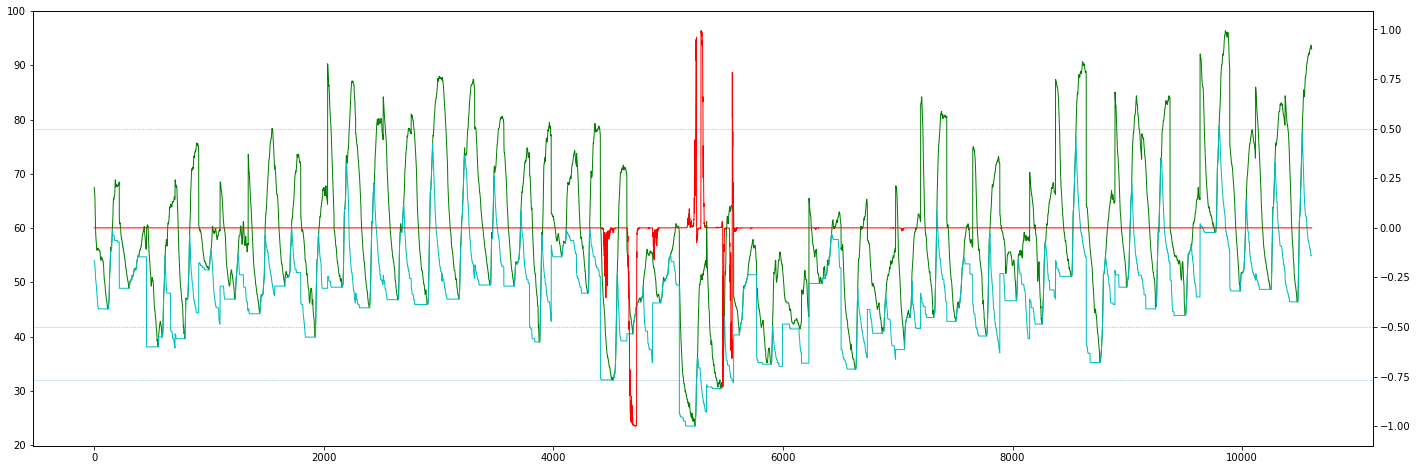

In [14]:
fig, ax1 = plt.subplots(figsize=(24,8))
ax2 = ax1.twinx()
ax1.plot(validation_data.TemperatureF.as_matrix(), 'g', lw=1)
ax1.plot(validation_data.forward_min.as_matrix(), 'c', lw=1)
ax2.plot(val_y-model.predict(val_x, batch_size=batch_size), 'r', lw=1)
ax2.axhline(0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
ax2.axhline(-0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)

ax1.axhline(32, ls='dashed', lw=0.5, alpha=0.5)
plt.show()

In [15]:
prediction_data = validation_data.assign(prediction = np.round(model.predict(val_x, batch_size=batch_size)).astype(int))
prediction_data.index = prediction_data.index.tz_convert('UTC')
prediction_data = prediction_data.merge(pd.get_dummies(prediction_data.prediction, prefix='prediction'), left_index=True, right_index=True)
prediction_data = prediction_data.assign(fn = prediction_data.threshold_32*prediction_data.prediction_0)
prediction_data = prediction_data.assign(fp = prediction_data.threshold_no*prediction_data.prediction_1)

In [16]:
resample = '2H'
extract = prediction_data.TemperatureF.resample(resample).min().to_frame().merge(prediction_data.forward_min.resample(resample).min().to_frame(), left_index=True, right_index=True).merge(prediction_data.threshold_32.resample(resample).max().to_frame(), left_index=True, right_index=True).merge(prediction_data.prediction_1.resample(resample).max().to_frame(), left_index=True, right_index=True).merge(prediction_data.fn.resample(resample).prod().to_frame(), left_index=True, right_index=True).merge(prediction_data.fp.resample(resample).prod().to_frame(), left_index=True, right_index=True)
extract.fp = extract.fp * 32
extract.fn = extract.fn * 32
extract.fp[extract.fp==0] = float('nan')
extract.fn[extract.fn==0] = float('nan')
extract.fn.count(), extract.fp.count()

(0, 3)

In [17]:
model.save(model_path+'model.h5')